<a href="https://colab.research.google.com/github/dauparas/pytorch_examples/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create some data

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

N = 500
X = np.random.uniform(-1.0, 1.0, N)
Y = 0.25*X+0.05*np.random.normal(0.0, 1.0, N)

X = X[:, np.newaxis]
Y = Y[:, np.newaxis]

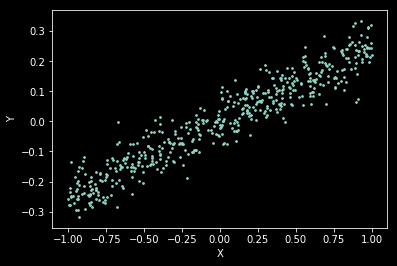

In [159]:
plt.scatter(X, Y, s=3.0);
plt.xlabel('X');
plt.ylabel('Y');

# PyTorch model

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [0]:
class MyDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [0]:
batch_size = 16
random_seed = 0
learning_rate = 1e-3
num_epochs = 100

In [0]:
dataset = MyDataset(X, Y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

In [166]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class LinearReg(torch.nn.Module):

    def __init__(self, num_features):
        super(LinearReg, self).__init__()
        
        self.linear_1 = nn.Linear(num_features, 1)
        
    def forward(self, x):
        out = self.linear_1(x)
        return out

torch.manual_seed(random_seed)
model = LinearReg(num_features=X.shape[1])
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [168]:
%%time
for epoch in range(num_epochs):
    model.train()
    criterion = nn.MSELoss()
    for batch_idx, (features, targets) in enumerate(loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        logits = model(features)
        cost = criterion(logits, targets)
        optimizer.zero_grad()
        cost.backward()
  
        optimizer.step()

    if (epoch+1) % 10 == 0 or epoch == 0 :
      print ('Epoch: %03d | Cost: %.4f' %(epoch+1, cost))

Epoch: 001 | Cost: 0.2323
Epoch: 010 | Cost: 0.0922
Epoch: 020 | Cost: 0.0197
Epoch: 030 | Cost: 0.0029
Epoch: 040 | Cost: 0.0029
Epoch: 050 | Cost: 0.0006
Epoch: 060 | Cost: 0.0011
Epoch: 070 | Cost: 0.0016
Epoch: 080 | Cost: 0.0096
Epoch: 090 | Cost: 0.0005
Epoch: 100 | Cost: 0.0024
CPU times: user 9.1 s, sys: 5.85 s, total: 14.9 s
Wall time: 17.3 s


In [0]:
model.eval()
logits_ = []
features_ = []
cost_ = 0.0
with torch.no_grad():
  for batch_idx, (features, targets) in enumerate(loader):
    features = features.to(device)
    targets = targets.to(device)
    logits = model(features)
    cost = criterion(logits, targets)

    logits_.append(logits)
    features_.append(features)
    cost_ += cost*features.size(0)/X.shape[0]

  logits_ = torch.cat(logits_, dim=0)
  features_ = torch.cat(features_, dim=0)

  cost_ = cost_.cpu().numpy()
  logits_ = logits_.cpu().numpy()
  features_ = features_.cpu().numpy()

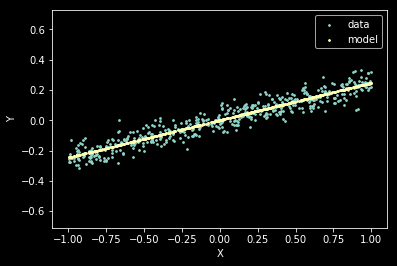

In [170]:
plt.scatter(X, Y, s=3.0);
plt.scatter(features_, logits_, s=3.0);
plt.axis('equal');
plt.xlabel('X');
plt.ylabel('Y');
plt.legend(('data', 'model'));